Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [ ]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

Unconditional grammar outputs look like this:

In [ ]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

In [ ]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict=root_inst_dict,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [ ]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

In [ ]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [ ]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

In [ ]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict=root_inst_dict,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(100)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [36]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
encoder = GrammarEncoder(inference_grammar, 512)
x = encoder(observed_nodes_for_training[0])

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

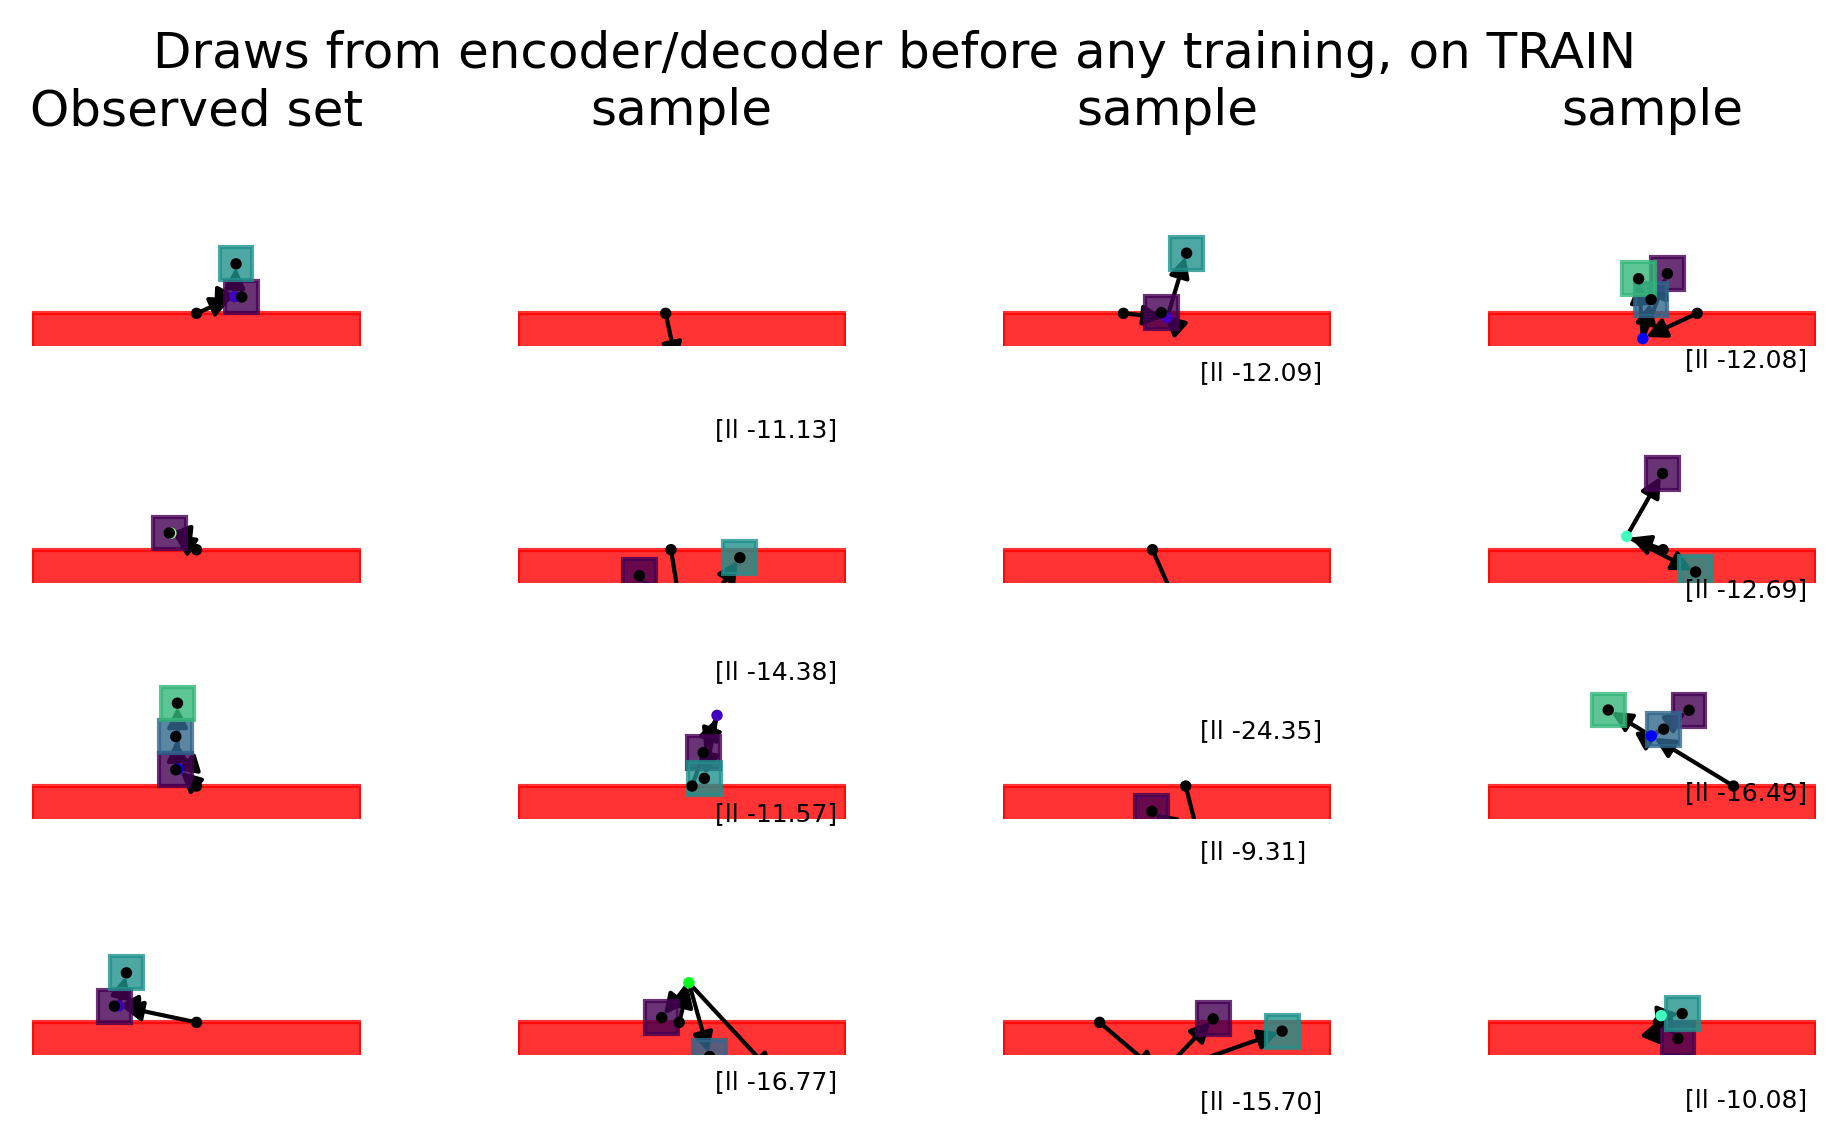

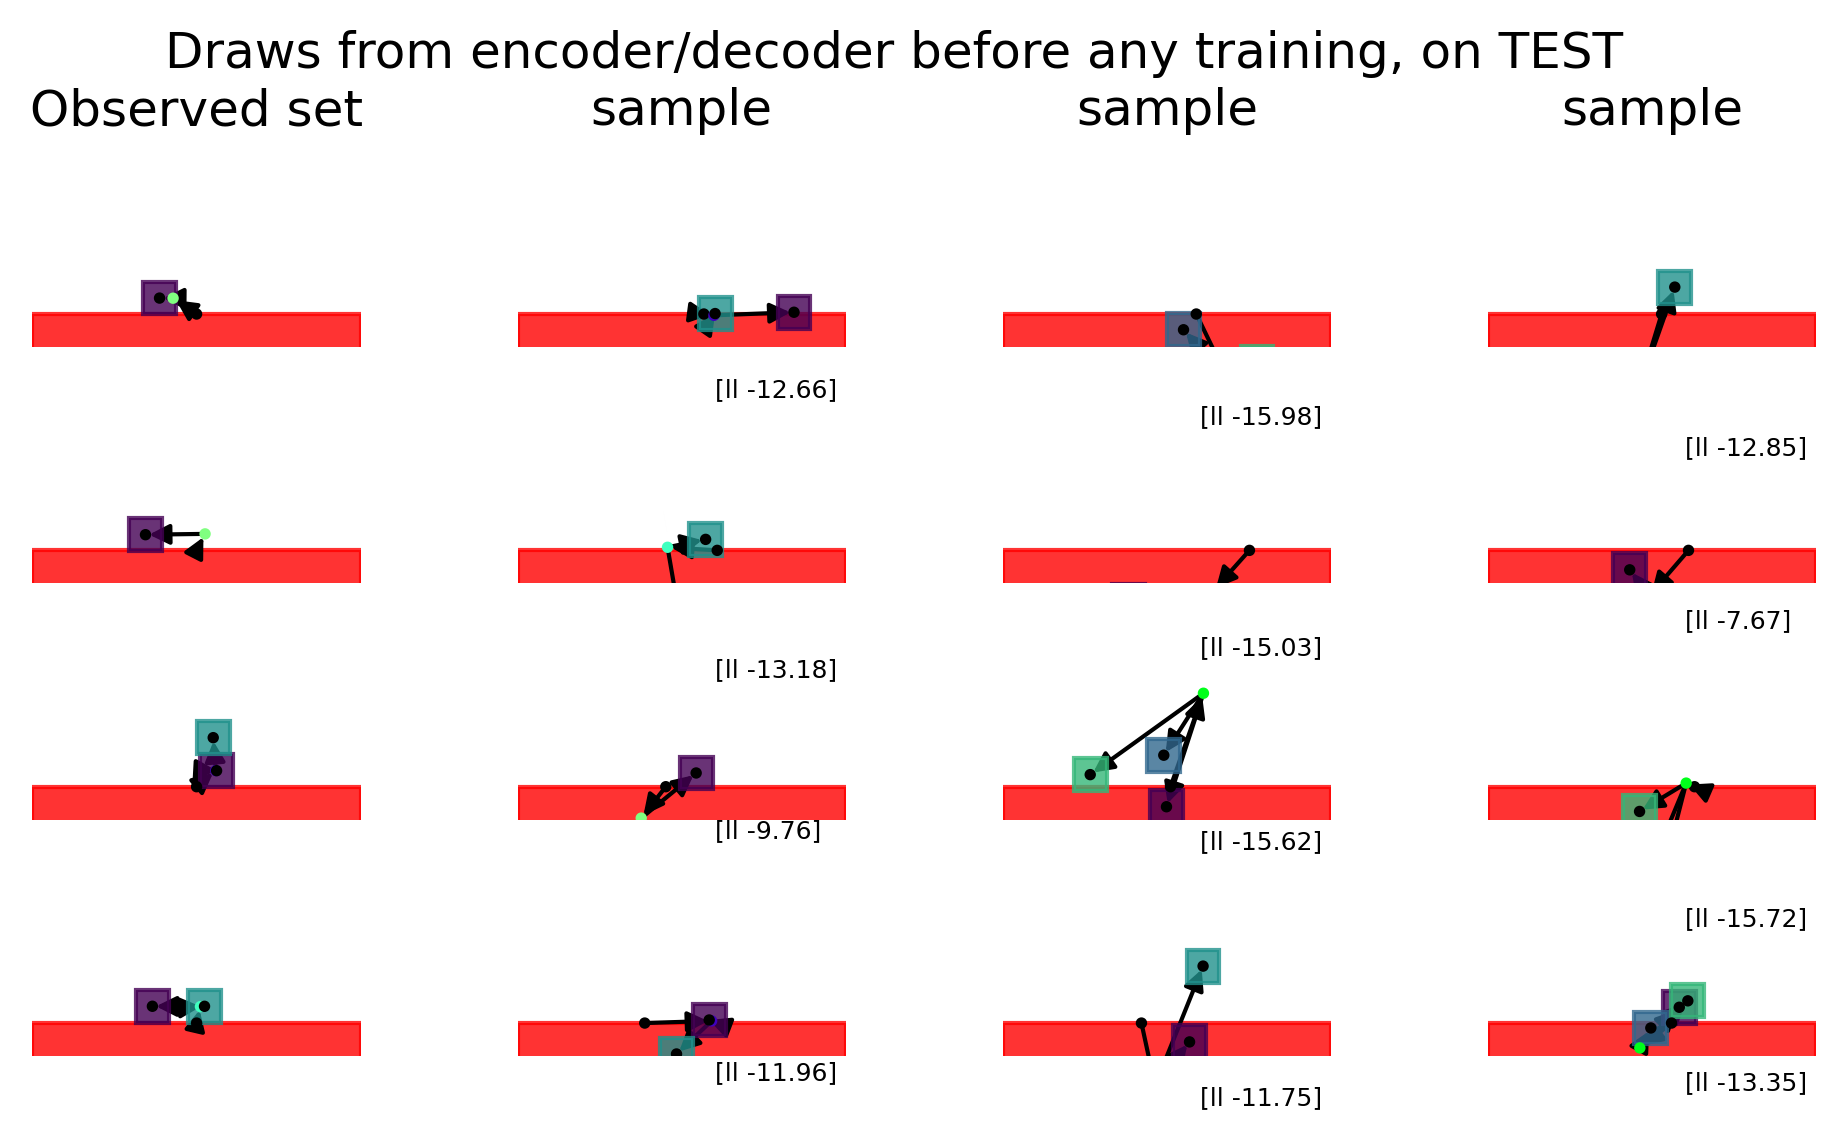

In [37]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [38]:
# Training
N_EPOCHS = 600
N_ITERS_PER_EPOCH = 100

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0025)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,300,450], gamma=0.33)
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll

        full_tree = full_trees_for_training[iter_k]
        full_tree_score = encoder.score_tree_with_grammar_vector(full_tree, x)
        total_objective += full_tree_score

    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f"
              % (epoch, mean_objective))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
supervised_training_finish_time = time.time()

0:Mean objective -12.56
1:Mean objective -10.49
2:Mean objective -9.30
3:Mean objective -8.23
4:Mean objective -7.16
5:Mean objective -6.12
6:Mean objective -5.20
7:Mean objective -4.42
8:Mean objective -3.53
9:Mean objective -2.43
10:Mean objective -1.73
11:Mean objective -2.86
12:Mean objective -3.93
13:Mean objective -1.07
14:Mean objective -0.20
15:Mean objective -1.69
16:Mean objective 1.19
17:Mean objective 0.28
18:Mean objective 1.07
19:Mean objective 0.93
20:Mean objective 2.25
21:Mean objective 1.69
22:Mean objective 1.73
23:Mean objective 2.54
24:Mean objective 2.97
25:Mean objective 3.29
26:Mean objective 2.54
27:Mean objective 1.04
28:Mean objective 2.55
29:Mean objective 2.71
30:Mean objective 3.74
31:Mean objective 3.96
32:Mean objective 4.35
33:Mean objective 4.28
34:Mean objective 4.41
35:Mean objective 4.57
36:Mean objective 5.13
37:Mean objective 4.99
38:Mean objective 5.04
39:Mean objective 3.90
40:Mean objective 5.55
41:Mean objective 5.89
42:Mean objective 6.18
43:

338:Mean objective 15.58
339:Mean objective 15.63
340:Mean objective 15.65
341:Mean objective 15.71
342:Mean objective 15.69
343:Mean objective 15.66
344:Mean objective 15.74
345:Mean objective 15.76
346:Mean objective 15.79
347:Mean objective 15.81
348:Mean objective 15.84
349:Mean objective 15.87
350:Mean objective 15.83
351:Mean objective 15.88
352:Mean objective 15.89
353:Mean objective 15.93
354:Mean objective 15.96
355:Mean objective 15.97
356:Mean objective 16.01
357:Mean objective 16.02
358:Mean objective 16.08
359:Mean objective 16.08
360:Mean objective 16.13
361:Mean objective 16.16
362:Mean objective 16.09
363:Mean objective 16.16
364:Mean objective 16.08
365:Mean objective 16.06
366:Mean objective 16.04
367:Mean objective 16.26
368:Mean objective 16.24
369:Mean objective 16.17
370:Mean objective 16.27
371:Mean objective 16.37
372:Mean objective 16.30
373:Mean objective 16.33
374:Mean objective 16.46
375:Mean objective 16.44
376:Mean objective 16.38
377:Mean objective 16.43


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

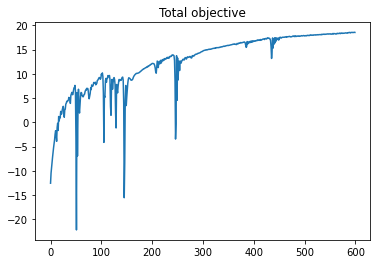

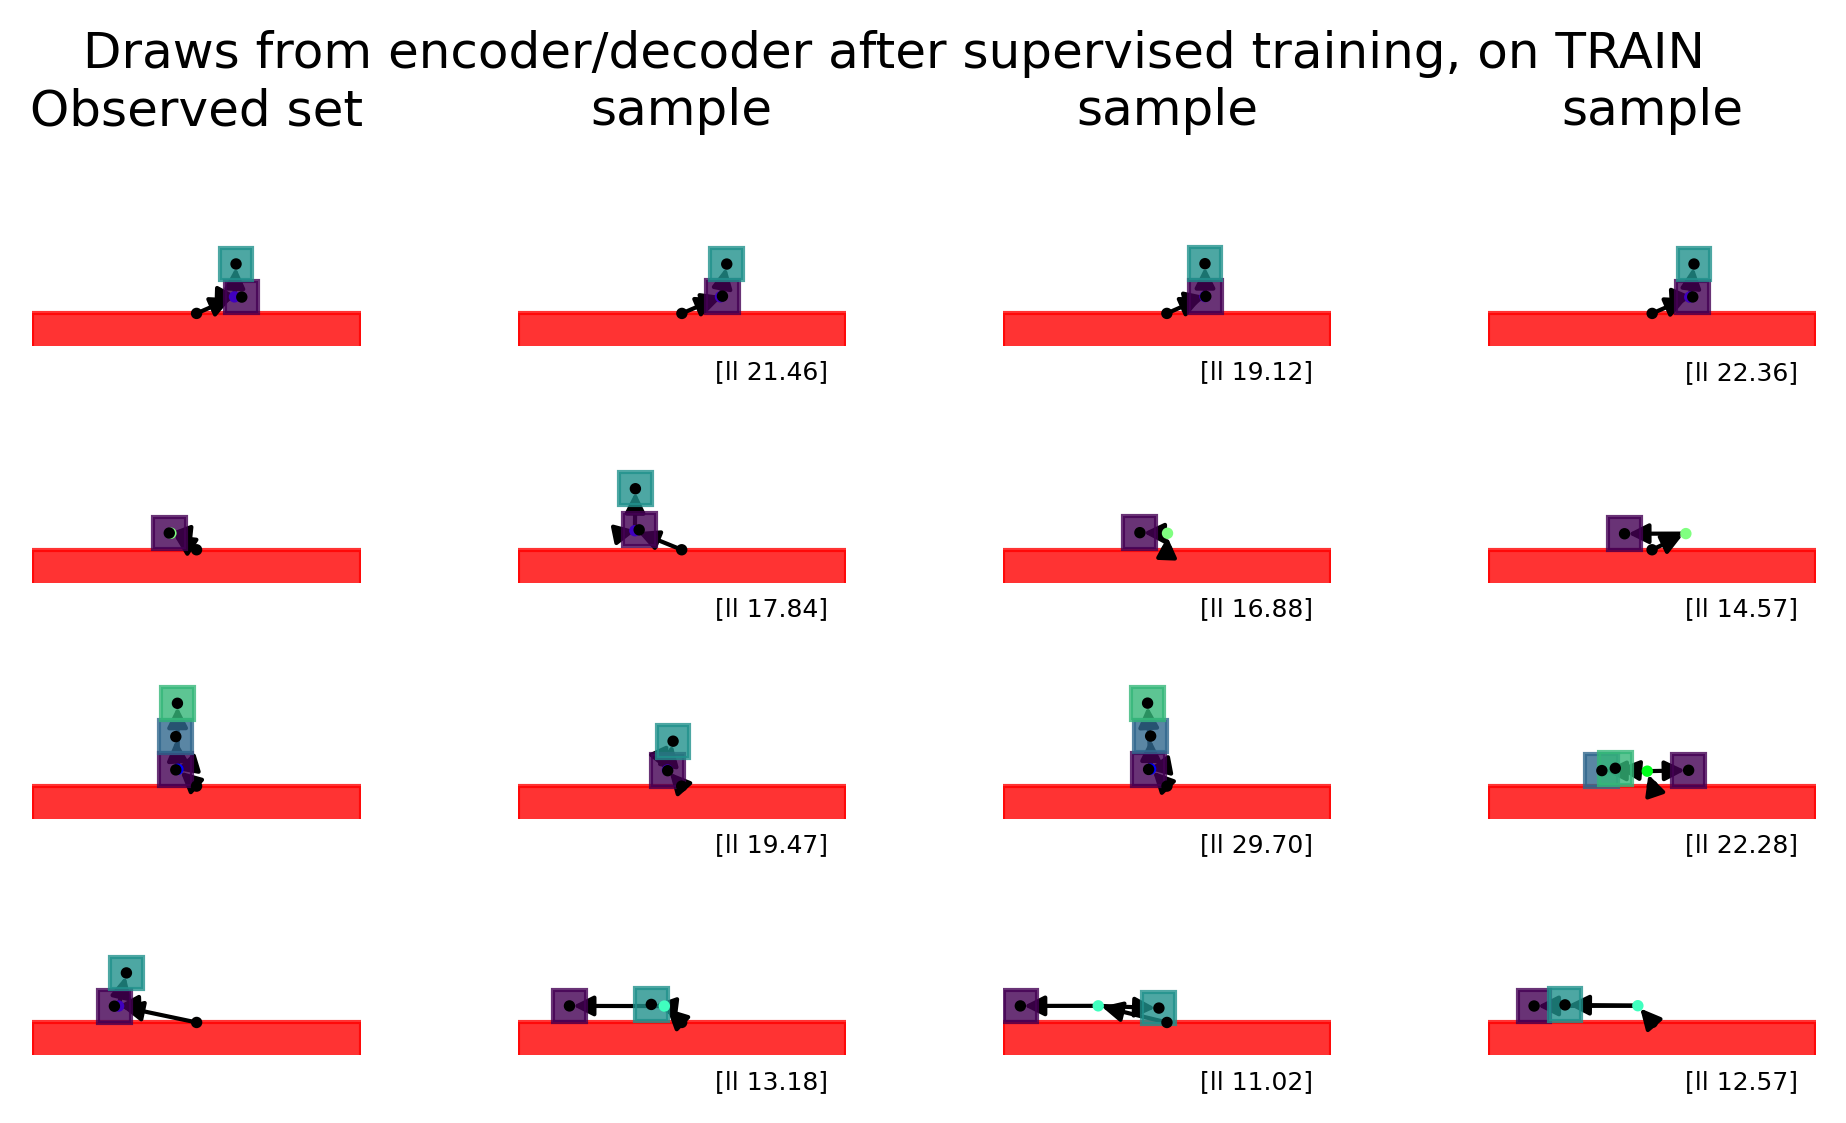

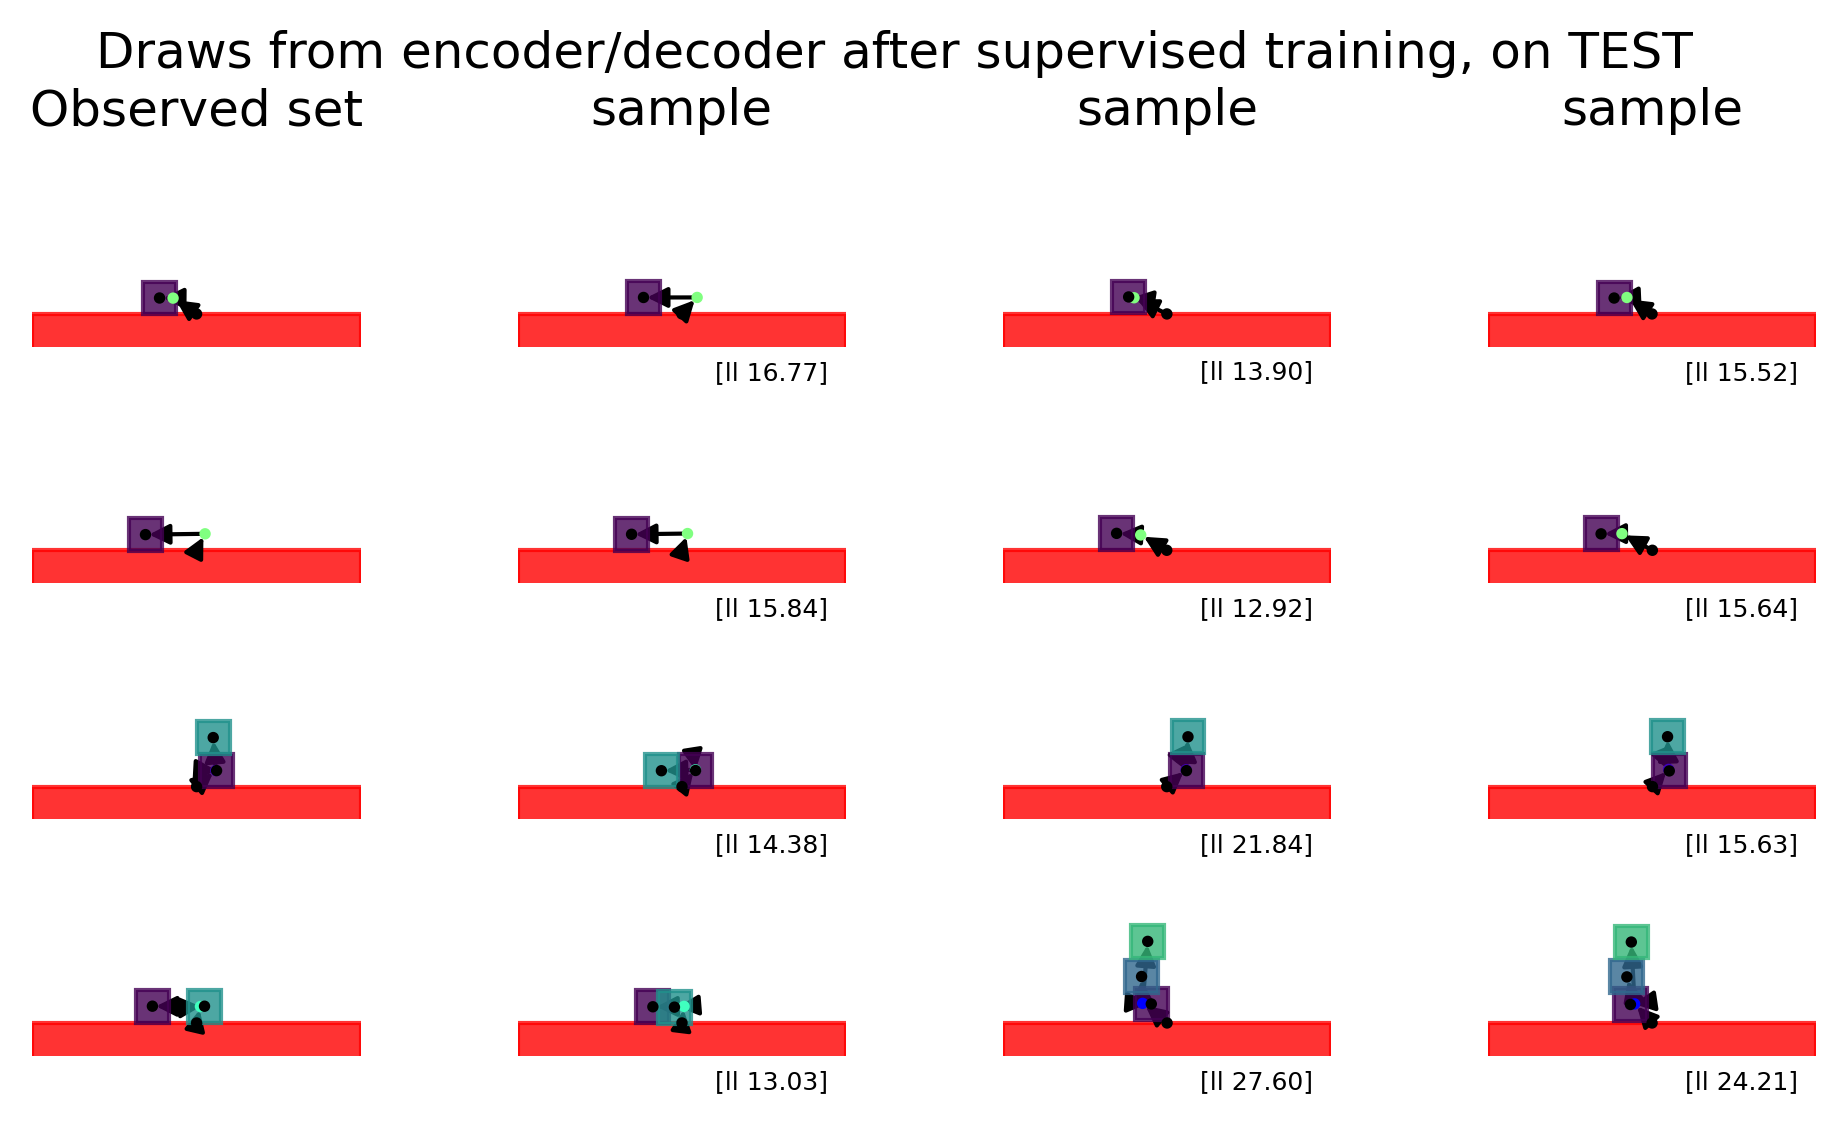

In [40]:
plt.plot(total_objective_history)
plt.title("Total objective")

def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [41]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_supervised_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)

Saved model to saved_models/20210506/encoder_supervised_18.5431.torch


# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [42]:
# Training
N_EPOCHS = 450
N_ITERS_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 5
MIN_LL_SATURATION = -10000

torch.manual_seed(43)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,300], gamma=0.33)
mean_sampled_f_history = []
mean_sampled_score_history = []
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

unsupervised_training_finish_time = time.time()

# Test gradient
#from torchviz import make_dot
#make_dot(mean_sampled_f, params=dict(encoder.named_parameters()))

0: Mean sampled loss -64.62, f -64.62, Mean objective 46.66
1: Mean sampled loss -63.09, f -63.09, Mean objective -19.39
2: Mean sampled loss -100.34, f -100.34, Mean objective -17.66
3: Mean sampled loss -47.22, f -47.22, Mean objective -7.71
4: Mean sampled loss -40.96, f -40.96, Mean objective -41.38
5: Mean sampled loss -52.22, f -52.22, Mean objective -29.67
6: Mean sampled loss -46.70, f -46.70, Mean objective -27.88
7: Mean sampled loss -51.57, f -51.57, Mean objective -16.90
8: Mean sampled loss -64.56, f -64.56, Mean objective 1.29
9: Mean sampled loss -54.48, f -54.48, Mean objective -9.01
10: Mean sampled loss -32.94, f -32.94, Mean objective -27.78
11: Mean sampled loss -62.15, f -62.15, Mean objective 10.24
12: Mean sampled loss -50.55, f -50.55, Mean objective -30.65
13: Mean sampled loss -44.22, f -44.22, Mean objective -35.99
14: Mean sampled loss -43.61, f -43.61, Mean objective -15.08
15: Mean sampled loss -57.23, f -57.23, Mean objective -0.12
16: Mean sampled loss -

134: Mean sampled loss -27.92, f -27.92, Mean objective -10.72
135: Mean sampled loss -21.54, f -21.54, Mean objective -11.92
136: Mean sampled loss -32.55, f -32.55, Mean objective -13.20
137: Mean sampled loss -32.85, f -32.85, Mean objective 0.35
138: Mean sampled loss -17.31, f -17.31, Mean objective -9.04
139: Mean sampled loss -43.08, f -43.08, Mean objective -5.35
140: Mean sampled loss -64.74, f -64.74, Mean objective 3.58
141: Mean sampled loss -34.66, f -34.66, Mean objective -5.49
142: Mean sampled loss -11.32, f -11.32, Mean objective -6.89
143: Mean sampled loss -20.60, f -20.60, Mean objective -6.11
144: Mean sampled loss -26.39, f -26.39, Mean objective -16.02
145: Mean sampled loss -17.18, f -17.18, Mean objective -19.02
146: Mean sampled loss -42.48, f -42.48, Mean objective 1.93
147: Mean sampled loss -16.68, f -16.68, Mean objective -14.52
148: Mean sampled loss -26.11, f -26.11, Mean objective -7.68
149: Mean sampled loss -23.78, f -23.78, Mean objective -13.92
150:

267: Mean sampled loss -68.61, f -68.61, Mean objective -12.94
268: Mean sampled loss -41.86, f -41.86, Mean objective -13.40
269: Mean sampled loss -41.21, f -41.21, Mean objective -13.40
270: Mean sampled loss -26.60, f -26.60, Mean objective -6.73
271: Mean sampled loss -9.42, f -9.42, Mean objective -12.37
272: Mean sampled loss -32.91, f -32.91, Mean objective -23.99
273: Mean sampled loss -17.86, f -17.86, Mean objective -14.20
274: Mean sampled loss -11.55, f -11.55, Mean objective -11.46
275: Mean sampled loss -34.35, f -34.35, Mean objective 11.64
276: Mean sampled loss -24.86, f -24.86, Mean objective -22.12
277: Mean sampled loss -5.41, f -5.41, Mean objective -3.43
278: Mean sampled loss -16.89, f -16.89, Mean objective -1.90
279: Mean sampled loss -18.31, f -18.31, Mean objective -8.59
280: Mean sampled loss -18.13, f -18.13, Mean objective 5.74
281: Mean sampled loss -26.59, f -26.59, Mean objective 4.33
282: Mean sampled loss -32.65, f -32.65, Mean objective 3.67
283: Me

399: Mean sampled loss -18.89, f -18.89, Mean objective -13.26
400: Mean sampled loss -10.97, f -10.97, Mean objective -5.62
401: Mean sampled loss -46.28, f -46.28, Mean objective -9.45
402: Mean sampled loss -27.41, f -27.41, Mean objective -4.90
403: Mean sampled loss -49.25, f -49.25, Mean objective -18.78
404: Mean sampled loss -49.58, f -49.58, Mean objective -1.49
405: Mean sampled loss -28.07, f -28.07, Mean objective -20.42
406: Mean sampled loss -7.26, f -7.26, Mean objective -7.90
407: Mean sampled loss -56.06, f -56.06, Mean objective 0.83
408: Mean sampled loss -38.26, f -38.26, Mean objective 4.91
409: Mean sampled loss -8.52, f -8.52, Mean objective -13.41
410: Mean sampled loss -27.03, f -27.03, Mean objective -21.53
411: Mean sampled loss -43.10, f -43.10, Mean objective -19.00
412: Mean sampled loss -31.95, f -31.95, Mean objective -9.19
413: Mean sampled loss -17.32, f -17.32, Mean objective -15.55
414: Mean sampled loss -16.16, f -16.16, Mean objective -6.77
415: Me

Text(0.5, 1.0, 'Total objective')

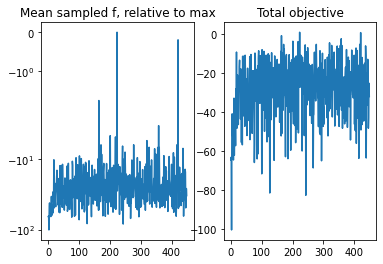

In [43]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Text(0.5, 0.98, 'Draws from encoder/decoder after unsupervised training, on TEST')

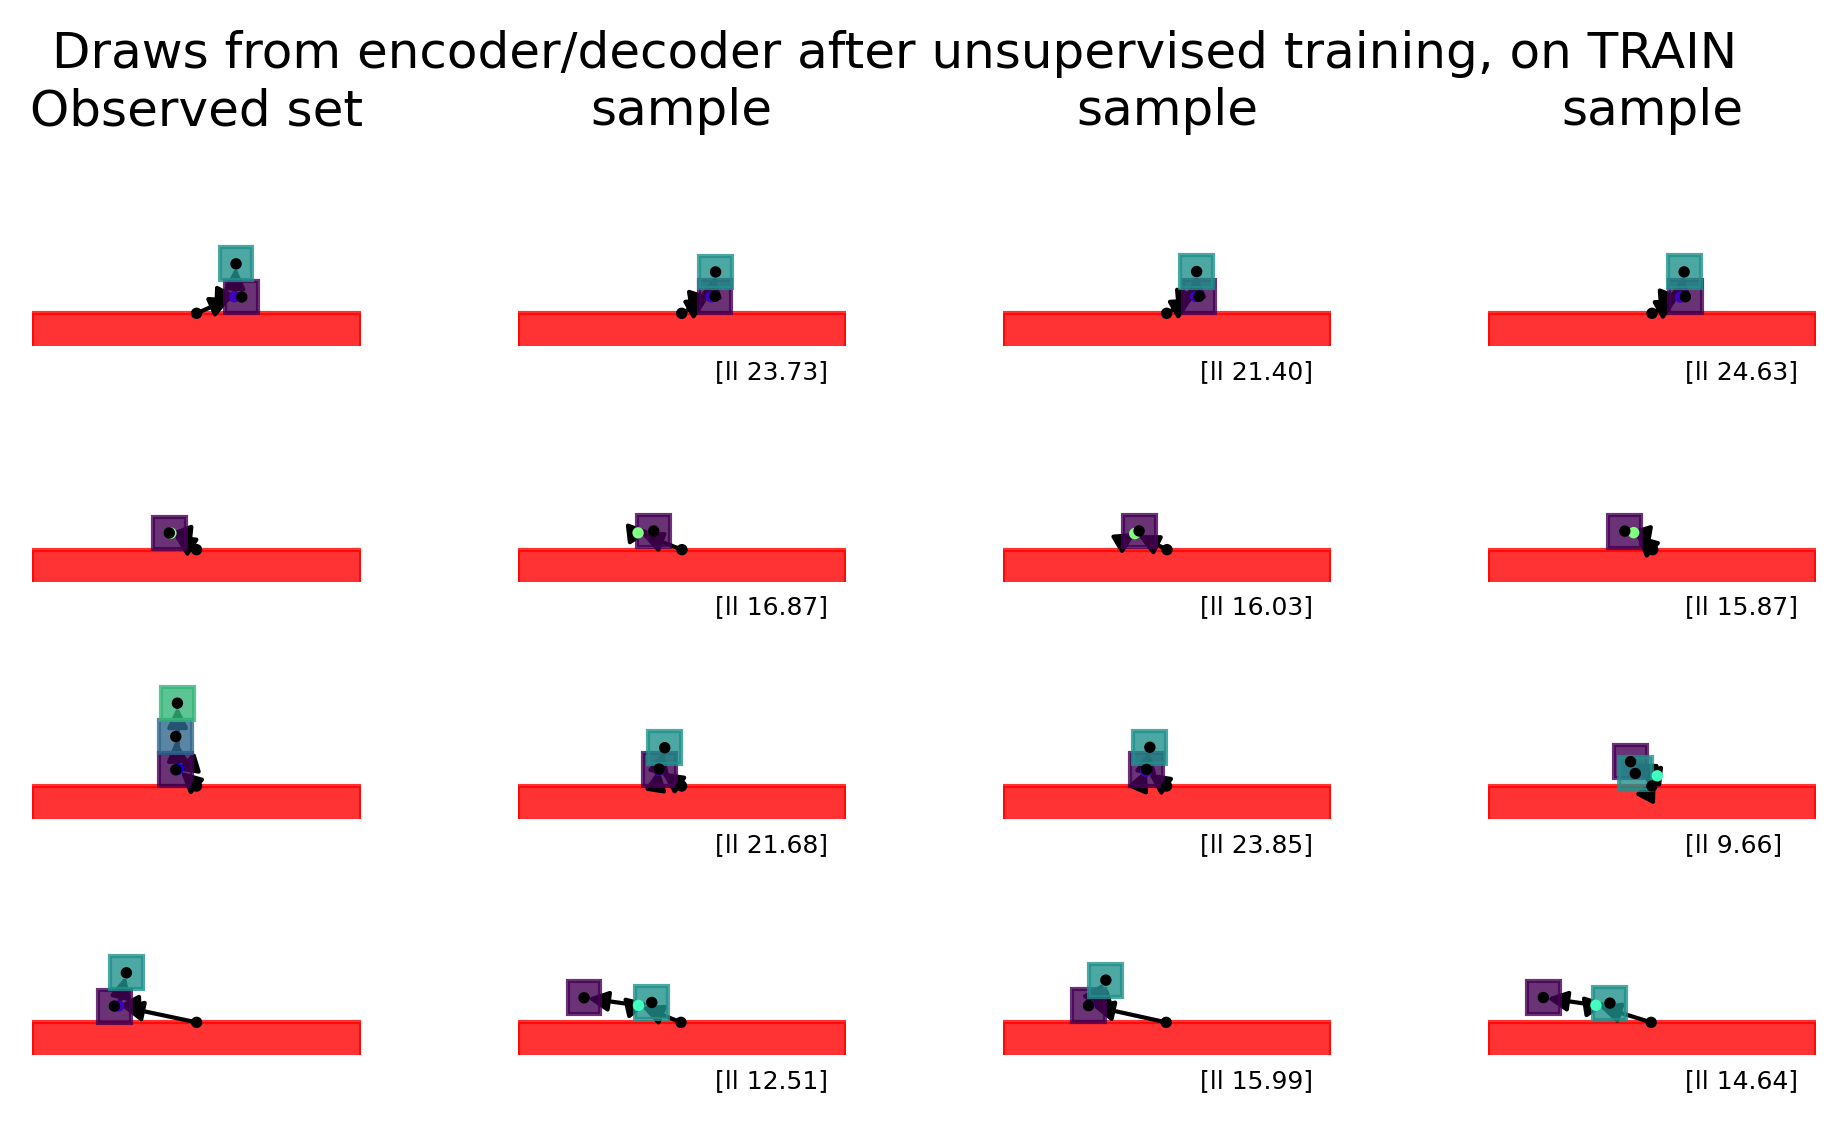

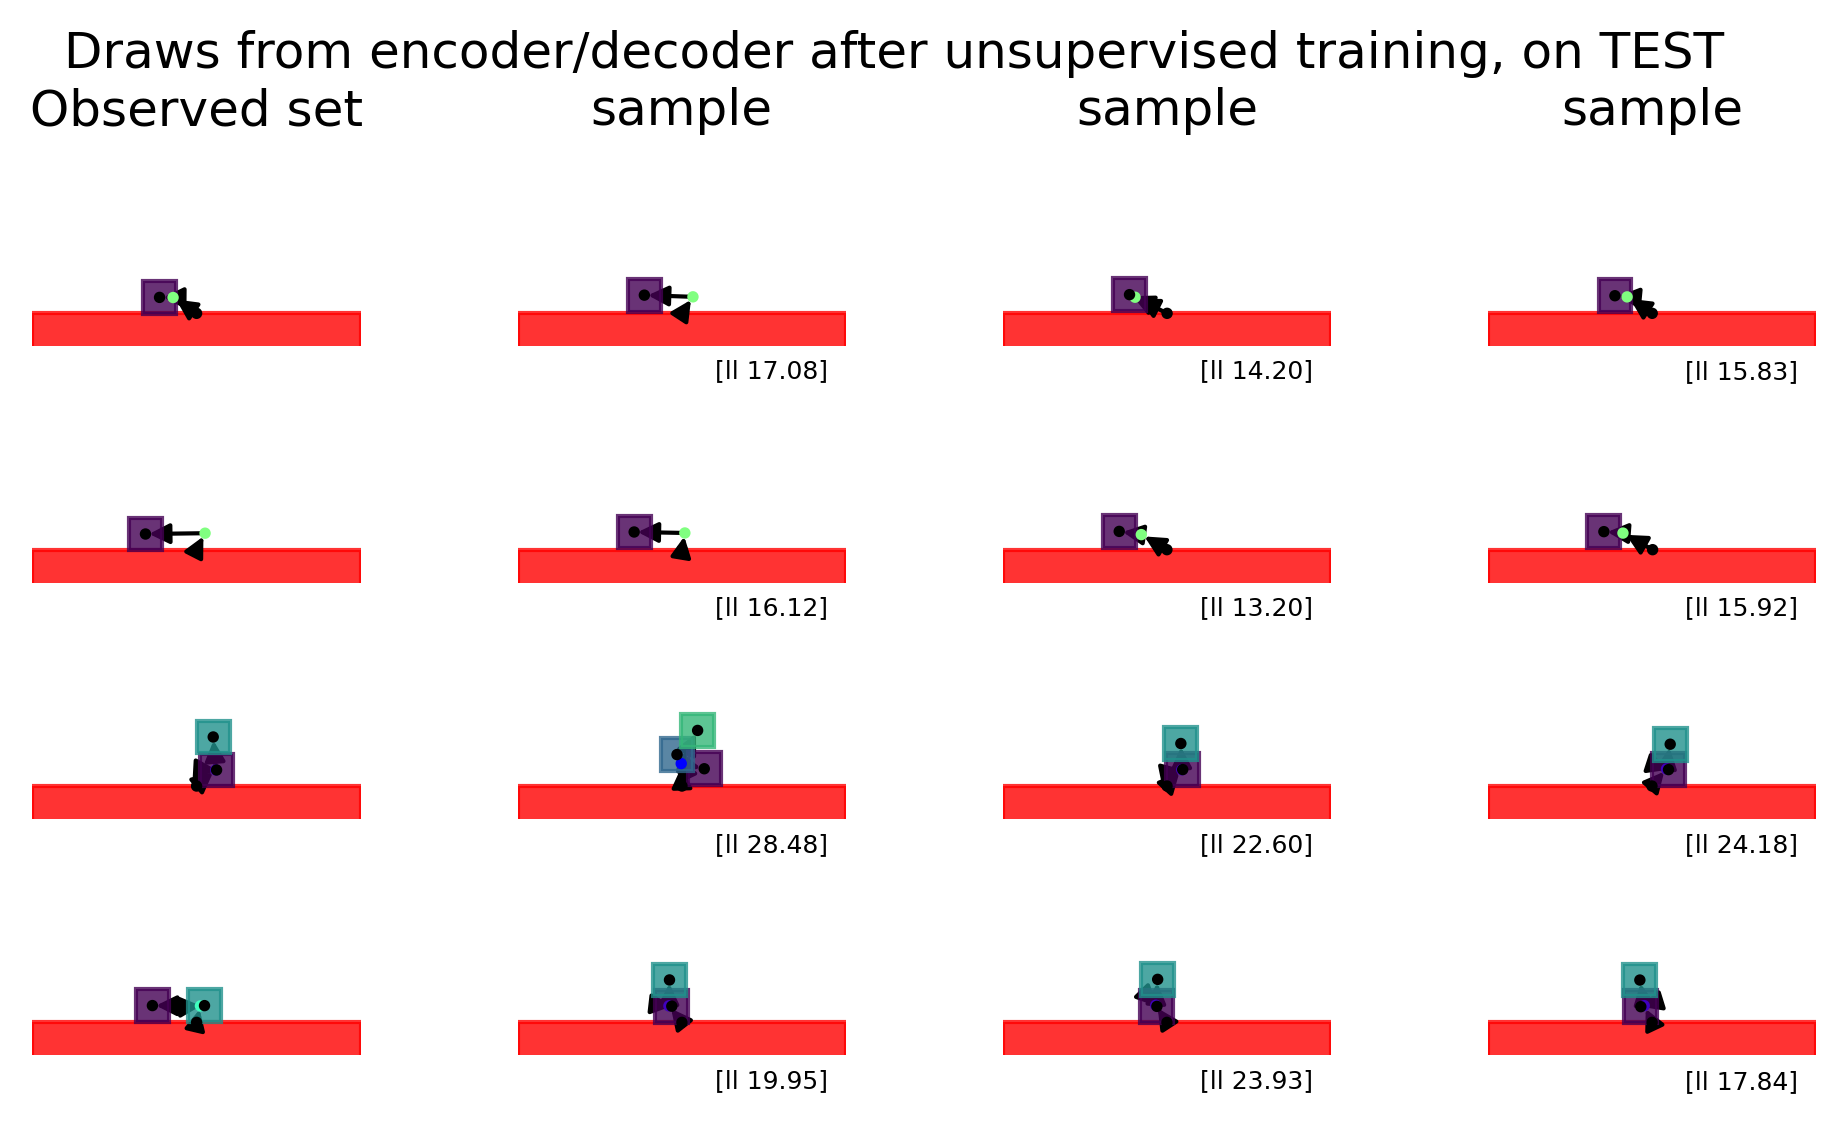

In [44]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)